In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Cấu hình hiển thị cho đẹp
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# --- BƯỚC 1: TẢI DỮ LIỆU ---
# Giả sử bạn đã tải file 'Beijing_PM25_Data.csv' lên cùng thư mục
# Nếu dùng Google Colab, bạn cần upload file csv lên trước
try:
    # Đọc file CSV, ghép các cột ngày tháng thành 1 cột datetime index
    df = pd.read_csv('Beijing_PM25_Data.csv', 
                     parse_dates=[['year', 'month', 'day', 'hour']], 
                     date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))
    
    # Đổi tên cột index thành 'Time' cho dễ gọi
    df.rename(columns={'year_month_day_hour': 'Time'}, inplace=True)
    df.set_index('Time', inplace=True)
    
    print("✅ Đã tải dữ liệu thành công!")
    print(f"Tổng số dòng: {df.shape[0]}, Tổng số cột: {df.shape[1]}")

except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file 'Beijing_PM25_Data.csv'. Hãy kiểm tra lại tên file.")

# Xem 5 dòng đầu tiên
print("\n--- 5 Dòng dữ liệu thô đầu tiên ---")
display(df.head())

C:\Users\HOME\AppData\Local\Temp\ipykernel_22672\1326386771.py:16: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('Beijing_PM25_Data.csv',
C:\Users\HOME\AppData\Local\Temp\ipykernel_22672\1326386771.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('Beijing_PM25_Data.csv',


✅ Đã tải dữ liệu thành công!
Tổng số dòng: 43824, Tổng số cột: 9

--- 5 Dòng dữ liệu thô đầu tiên ---


,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Time,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
# --- BƯỚC 2: LÀM SẠCH DỮ LIỆU (DATA CLEANING) ---

# Kiểm tra số lượng giá trị thiếu (NA) ban đầu
print("Số lượng NA trước khi xử lý:")
print(df[['pm2.5', 'TEMP', 'Iws', 'DEWP']].isnull().sum())

# 2.1. Nội suy tuyến tính cho PM2.5
# Lý do: Nồng độ bụi biến thiên liên tục, không đứt quãng
df['pm2.5'] = df['pm2.5'].interpolate(method='linear')

# 2.2. Xử lý các biến khí tượng khác
# Với các biến như TEMP, Iws nếu thiếu ít thì fillna, nếu thiếu nhiều thì drop
# Ở đây ta chọn cách drop các dòng thiếu dữ liệu khí tượng (vì số lượng thường ít)
df_clean = df.dropna(subset=['TEMP', 'Iws', 'DEWP', 'PRES', 'cbwd'])

print(f"\nSố lượng dòng sau khi làm sạch: {len(df_clean)} (Đã loại bỏ {len(df) - len(df_clean)} dòng lỗi)")

# Kiểm tra lại xem còn NA không
if df_clean['pm2.5'].isnull().sum() == 0:
    print("✅ Cột PM2.5 đã sạch hoàn toàn.")

Số lượng NA trước khi xử lý:
pm2.5    24
TEMP      0
Iws       0
DEWP      0
dtype: int64

Số lượng dòng sau khi làm sạch: 43824 (Đã loại bỏ 0 dòng lỗi)


In [9]:
# --- ĐOẠN CODE SỬA LỖI ---

# 1. Kiểm tra và xử lý PM2.5 trước
# Chặn giá trị PM2.5 tối đa ở mức hợp lý (ví dụ 1000 hoặc 2000 ug/m3 là mức không tưởng rồi)
# Điều này giúp tránh lỗi tràn số khi tính mũ exp
df_clean['pm2.5'] = df_clean['pm2.5'].clip(upper=2000)

# 2. Tính lại các chỉ số
beta_health = 0.000755
baseline_cases = 253

# Tính Risk Ratio
df_clean['Risk_Ratio'] = np.exp(beta_health * (df_clean['pm2.5'] - 10).clip(lower=0))

# Tính Expected Cases
df_clean['Expected_Cases'] = baseline_cases * df_clean['Risk_Ratio']

# 3. Xử lý an toàn trước khi đưa vào Poisson
# Thay thế các giá trị vô cực (inf) hoặc NaN bằng giá trị trung bình hoặc 0
df_clean['Expected_Cases'] = df_clean['Expected_Cases'].replace([np.inf, -np.inf], np.nan)
df_clean['Expected_Cases'] = df_clean['Expected_Cases'].fillna(baseline_cases)

# Kiểm tra xem có giá trị nào quá lớn không (ví dụ > 1 triệu ca/ngày là vô lý)
# Nếu có, gán về mức trần (ví dụ 10.000) để code chạy được
df_clean['Expected_Cases'] = df_clean['Expected_Cases'].clip(upper=10000) 

# 4. Chạy lại hàm Poisson
np.random.seed(42)
try:
    df_clean['Health_Outcome'] = np.random.poisson(df_clean['Expected_Cases'])
    print("✅ Đã khắc phục lỗi và tính toán xong cột Health_Outcome")
except ValueError as e:
    print(f"❌ Vẫn còn lỗi: {e}")
    print("Max PM2.5:", df_clean['pm2.5'].max())
    print("Max Expected Cases:", df_clean['Expected_Cases'].max())

# 5. Tiếp tục quy trình cũ
df_final = df_clean.dropna(subset=['delta_C'])
print(df_final[['pm2.5', 'Expected_Cases', 'Health_Outcome']].head())

✅ Đã khắc phục lỗi và tính toán xong cột Health_Outcome
                     pm2.5  Expected_Cases  Health_Outcome
Time                                                      
2010-01-02 00:00:00  129.0      276.783189             295
2010-01-02 01:00:00  148.0      280.782259             270
2010-01-02 02:00:00  159.0      283.123865             262
2010-01-02 03:00:00  181.0      287.865826             302
2010-01-02 04:00:00  138.0      278.670335             289


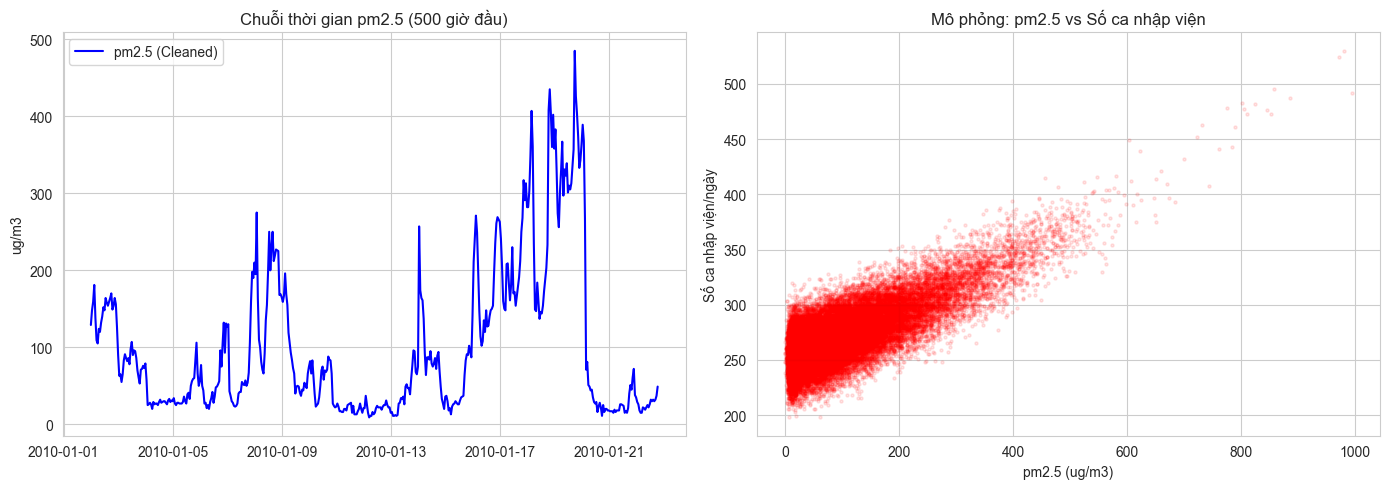

In [10]:
# --- BƯỚC 4: TRỰC QUAN HÓA ---

plt.figure(figsize=(14, 5))

# Biểu đồ 1: Chuỗi thời gian pm2.5
plt.subplot(1, 2, 1)
plt.plot(df_final.index[:500], df_final['pm2.5'][:500], label='pm2.5 (Cleaned)', color='blue')
plt.title('Chuỗi thời gian pm2.5 (500 giờ đầu)')
plt.ylabel('ug/m3')
plt.legend()

# Biểu đồ 2: pm2.5 vs Sức khỏe
plt.subplot(1, 2, 2)
plt.scatter(df_final['pm2.5'], df_final['Health_Outcome'], alpha=0.1, color='red', s=5)
plt.title('Mô phỏng: pm2.5 vs Số ca nhập viện')
plt.xlabel('pm2.5 (ug/m3)')
plt.ylabel('Số ca nhập viện/ngày')

plt.tight_layout()
plt.show()

C:\Users\HOME\AppData\Local\Temp\ipykernel_22672\3712900459.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df.groupby('Wind_Regime')['pm2.5'].mean()


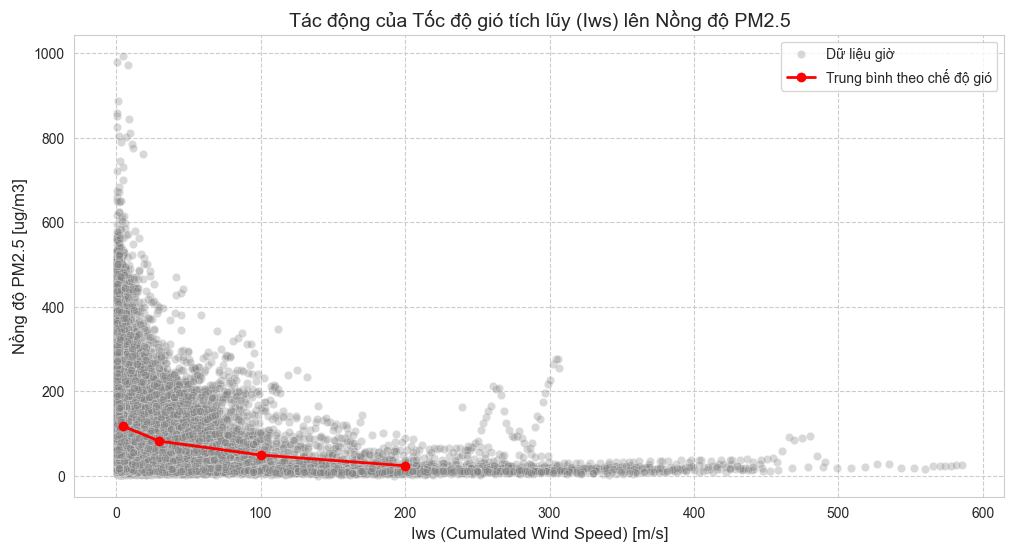

Nồng độ PM2.5 trung bình theo chế độ gió:
Wind_Regime
Tĩnh lặng (<10)        116.736095
Yếu (10-50)             81.726355
Trung bình (50-150)     48.855771
Mạnh (>150)             23.365514
Name: pm2.5, dtype: float64


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Đọc dữ liệu (Giả sử bạn đã load và làm sạch như chương 3)
# df_model là dataframe đã xử lý
# Đảm bảo có cột 'Iws' và 'PM2.5'

# 2. Phân nhóm Iws để vẽ Boxplot hoặc Scatter plot rõ hơn
# Tạo nhóm Iws theo các khoảng trong Bảng 1 tài liệu
bins = [0, 10, 50, 150, 1000]
labels = ['Tĩnh lặng (<10)', 'Yếu (10-50)', 'Trung bình (50-150)', 'Mạnh (>150)']
df['Wind_Regime'] = pd.cut(df['Iws'], bins=bins, labels=labels)

# 3. Vẽ biểu đồ Scatter plot với đường xu hướng
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Iws', y='pm2.5', alpha=0.3, color='gray', label='Dữ liệu giờ')

# Tính giá trị trung bình theo nhóm để vẽ điểm nhấn
mean_vals = df.groupby('Wind_Regime')['pm2.5'].mean()
plt.plot([5, 30, 100, 200], mean_vals.values, 'r-o', linewidth=2, label='Trung bình theo chế độ gió')

plt.title('Tác động của Tốc độ gió tích lũy (Iws) lên Nồng độ PM2.5', fontsize=14)
plt.xlabel('Iws (Cumulated Wind Speed) [m/s]', fontsize=12)
plt.ylabel('Nồng độ PM2.5 [ug/m3]', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# In giá trị trung bình để bạn chèn vào bài
print("Nồng độ PM2.5 trung bình theo chế độ gió:")
print(mean_vals)

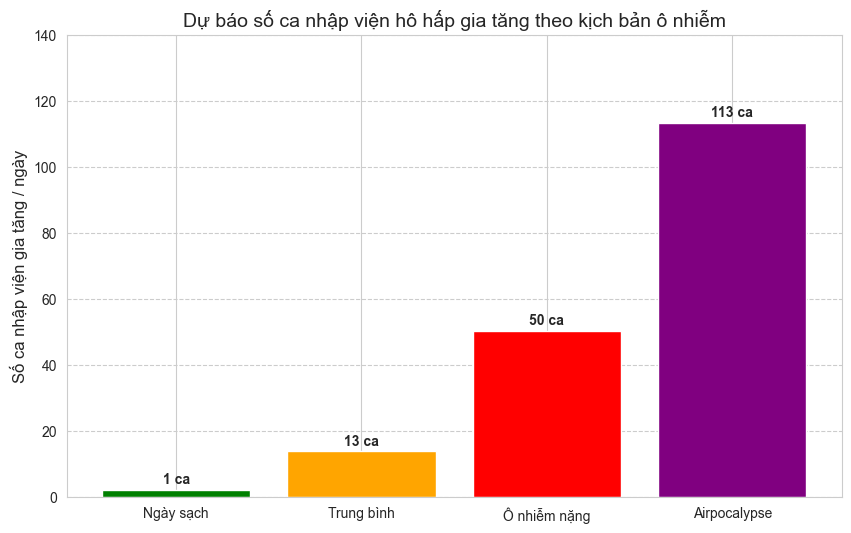

In [15]:
# Tham số dịch tễ từ tài liệu
beta = 0.000755  # Tăng 0.755% cho mỗi 10 ug/m3 -> beta ~ 0.000755 cho 1 đơn vị
Y0 = 253         # Ca nền

# Các kịch bản nồng độ bụi (Scenario)
scenarios = {
    'Ngày sạch': 20,
    'Trung bình': 80,
    'Ô nhiễm nặng': 250,
    'Airpocalypse': 500
}

# Tính toán
results = {}
for name, pm_val in scenarios.items():
    # Delta C so với mức an toàn (giả sử mức nền an toàn là 10)
    delta_C = pm_val - 10
    if delta_C < 0: delta_C = 0
    
    # Tính RR
    RR = np.exp(beta * delta_C)
    
    # Tính ca gia tăng
    excess_cases = Y0 * (RR - 1)
    results[name] = excess_cases

# Chuyển thành DataFrame để vẽ
df_res = pd.DataFrame(list(results.items()), columns=['Kịch bản', 'Số ca gia tăng'])

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(df_res['Kịch bản'], df_res['Số ca gia tăng'], color=['green', 'orange', 'red', 'purple'])

# Thêm số liệu lên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{int(yval)} ca', ha='center', fontweight='bold')

plt.title('Dự báo số ca nhập viện hô hấp gia tăng theo kịch bản ô nhiễm', fontsize=14)
plt.ylabel('Số ca nhập viện gia tăng / ngày', fontsize=12)
plt.ylim(0, 140) # Giới hạn trục y cho đẹp
plt.grid(axis='y', linestyle='--')
plt.show()